# 02 — Feature Engineering e Criação do Target

Este notebook carrega a base limpa (`ibov_clean.parquet`) e gera as features e o target para modelagem.
- Criação de lags (fechamento e retornos)
- Médias móveis
- Log do volume
- Target: 1 se fechamento do dia seguinte > dia atual, 0 caso contrário


In [14]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [15]:
root = Path('.').resolve()
in_path = root / 'data' / 'processed' / 'ibov_clean.parquet'
out_path = root / 'data' / 'processed' / 'ibov_features.parquet'

df = pd.read_parquet(in_path)
df.head()

,ultimo,maxima,minima,abertura,vol,return_d1
Date,,,,,,
2010-01-05,70240.0,70595.0,69928.0,70046.0,1984200,NaN
2010-01-06,70729.0,70937.0,70016.0,70237.0,2243600,0.006962
2010-01-07,70451.0,70723.0,70045.0,70723.0,1555000,-0.003930
2010-01-08,70263.0,70766.0,70158.0,70455.0,1634400,-0.002669
2010-01-11,70433.0,71068.0,70158.0,70267.0,1569000,0.002419


In [16]:
# --- Features ---
# retornos acumulados em janelas
df['var_pct'] = df['ultimo'].pct_change()

# log do volume
df['log_vol'] = np.log1p(df['vol'])

# lags de fechamento e retornos
for lag in [1,2,3,5,10]:
    df[f'close_lag{lag}'] = df['ultimo'].shift(lag)
    df[f'return_lag{lag}'] = df['var_pct'].shift(lag)

# retornos acumulados
for win in [5,10,20]:
    df[f'return_acc_{win}'] = df['var_pct'].rolling(win).sum()
    df[f'vol_{win}'] = df['vol'].rolling(win).mean()

# --- Target ---
df['target_next_day_up'] = (df['ultimo'].shift(-1) > df['ultimo']).astype(int)

# drop primeiras linhas com NaN
df = df.dropna()

df.head()

,ultimo,maxima,minima,abertura,vol,return_d1,var_pct,log_vol,close_lag1,return_lag1,...,return_lag5,close_lag10,return_lag10,return_acc_5,vol_5,return_acc_10,vol_10,return_acc_20,vol_20,target_next_day_up
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-03,67109.0,67347.0,66774.0,67163.0,1765000,-0.000804,-0.000804,14.383662,67163.0,0.008878,...,-0.006929,69909.0,0.007320,0.031088,1663960.0,-0.039851,1768320.0,-0.044364,1703680.0,0
2010-02-04,63934.0,67100.0,63750.0,67100.0,2262400,-0.047311,-0.047311,14.631937,67109.0,-0.000804,...,0.007961,68200.0,-0.024446,-0.024184,1786560.0,-0.062716,1795500.0,-0.098637,1704620.0,0
2010-02-05,62763.0,64001.0,61341.0,63934.0,3053000,-0.018316,-0.018316,14.931636,63934.0,-0.047311,...,-0.002836,66270.0,-0.028299,-0.039664,2032520.0,-0.052733,1874420.0,-0.113022,1779520.0,1
2010-02-08,63153.0,63923.0,62728.0,62760.0,1875600,0.006214,0.006214,14.444440,62763.0,-0.018316,...,0.017889,66220.0,-0.000754,-0.051339,2108760.0,-0.045764,1931480.0,-0.104140,1791580.0,1
2010-02-09,64718.0,65526.0,63164.0,63164.0,1357400,0.024781,0.024781,14.121082,63153.0,0.006214,...,0.008878,65524.0,-0.010510,-0.035436,2062680.0,-0.010473,1868180.0,-0.081778,1781000.0,1


In [17]:
# resumo das features
print(df.shape)
print("Exemplo de colunas:", list(df.columns[:15]))

(3870, 25)
Exemplo de colunas: ['ultimo', 'maxima', 'minima', 'abertura', 'vol', 'return_d1', 'var_pct', 'log_vol', 'close_lag1', 'return_lag1', 'close_lag2', 'return_lag2', 'close_lag3', 'return_lag3', 'close_lag5']


In [19]:
# balanceamento do target
prop = df['target_next_day_up'].value_counts(normalize=True)
print(prop)

target_next_day_up
1    0.509561
0    0.490439
Name: proportion, dtype: float64


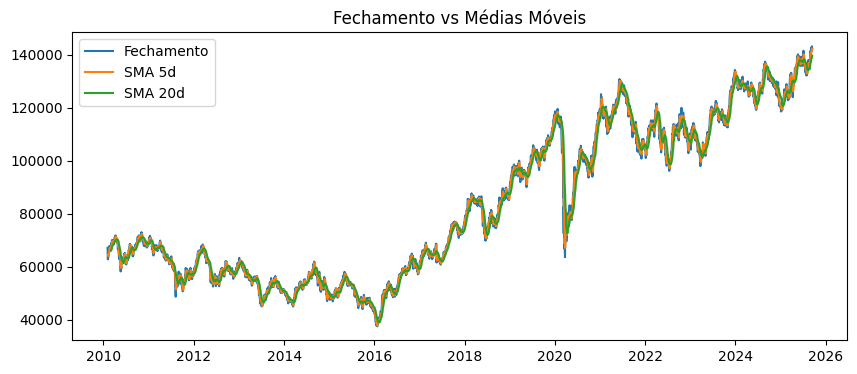

In [22]:
# plot médias móveis para sanity check
plt.figure(figsize=(10,4))
plt.plot(df.index, df['ultimo'], label='Fechamento')
plt.plot(df.index, df['ultimo'].rolling(5).mean(), label='SMA 5d')
plt.plot(df.index, df['ultimo'].rolling(20).mean(), label='SMA 20d')
plt.legend(); plt.title('Fechamento vs Médias Móveis')
plt.show()

In [23]:
# salvar parquet final
out_path.parent.mkdir(parents=True, exist_ok=True)
df.to_parquet(out_path)
str(out_path)

'C:\\Users\\mruther\\Documents\\FIAP\\FASE 2\\postech-challenge2\\notebooks\\data\\processed\\ibov_features.parquet'